## Classifying Penguins

Please review the following site for information on our dataset of interest here: 

https://allisonhorst.github.io/palmerpenguins

You can find the CSV file here: 

https://www.kaggle.com/datasets/parulpandey/palmer-archipelago-antarctica-penguin-data 

This is a very nice, simple dataset with which to apply clustering techniques, classification techniques, or play around with different visualization methods. Your goal is to use the other variables in the measurement variables in the dataset to predict (classify) species.

Assignment Specs:

- You should compare XGBoost or Gradient Boosting to the results of your previous AdaBoost activity.
- Based on the visualizations seen at the links above you're probably also thinking that this classification task should not be that difficult. So, a secondary goal of this assignment is to test the effects of the XGBoost (or Gradient Boosting) function arguments on the algorithm's performance. 
- You should explore at least 3 different sets of settings for the function inputs, and you should do your best to find values for these inputs that actually change the results of your modelling. That is, try not to run three different sets of inputs that result in the same performance. The goal here is for you to better understand how to set these input values yourself in the future. Comment on what you discover about these inputs and how they behave.
- Your submission should be built and written with non-experts as the target audience. All of your code should still be included, but do your best to narrate your work in accessible ways.

In [1]:
from palmerpenguins import load_penguins
import pandas as pd
import numpy as np
import random

df = load_penguins()
df.head()
df = df.dropna()

penguins = df.copy()

## AdaBoost Baseline

For reference, here are the results from the past practice activity: 


[AdaBoost] Best Params: {'classifier__learning_rate': 0.75, 'classifier__n_estimators': 200}
[AdaBoost] Test Classification Report:
              precision    recall  f1-score   support

      Adelie       0.95      0.95      0.95        44
   Chinstrap       0.95      0.90      0.92        20
      Gentoo       0.97      1.00      0.99        36

    accuracy                           0.96       100
   macro avg       0.96      0.95      0.95       100
weighted avg       0.96      0.96      0.96       100



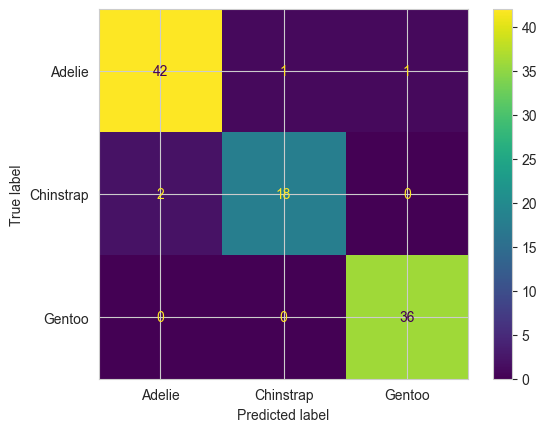

In [2]:
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.compose import ColumnTransformer
from sklearn.ensemble import AdaBoostClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.pipeline import Pipeline
from sklearn.model_selection import GridSearchCV, StratifiedKFold, train_test_split
from sklearn.metrics import classification_report, ConfusionMatrixDisplay


X = penguins.drop(columns="species")
y = penguins["species"]

# Train/test split
X_train, X_test, y_train, y_test = train_test_split(
    X, y, stratify=y, test_size=0.3, random_state=123
)

# Columns
categorical_features = ['sex', 'island']
numerical_features = X.select_dtypes(include='number').columns.tolist()

# ColumnTransformer
preprocessor = ColumnTransformer(transformers=[
    ('cat', OneHotEncoder(drop='first'), categorical_features),
    ('num', StandardScaler(), numerical_features)
])

# Base estimator for AdaBoost (from Sci-Kit Learn's Docu)
base_tree = DecisionTreeClassifier(max_depth=1, class_weight='balanced', random_state=123)

# Pipeline
ada_pipe = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('classifier', AdaBoostClassifier(estimator=base_tree, random_state=123))
])

# Grid Search
ada_param_grid = {
    'classifier__n_estimators': [25, 50, 100, 200],
    'classifier__learning_rate': [0.1, 0.5, 0.75, 1.0]
}

# Cross-validation strategy
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=123)

# Grid search
ada_grid = GridSearchCV(
    ada_pipe,
    param_grid=ada_param_grid,
    cv=cv,
    scoring='accuracy',
    n_jobs=-1
)

# Fit model
ada_grid.fit(X_train, y_train)

# Evaluate
best_ada = ada_grid.best_estimator_
y_pred_ada = best_ada.predict(X_test)

print(f"[AdaBoost] Best Params: {ada_grid.best_params_}")
print("[AdaBoost] Test Classification Report:")
print(classification_report(y_test, y_pred_ada))
ConfusionMatrixDisplay.from_estimator(best_ada, X_test, y_test)

In [3]:
results = pd.DataFrame(ada_grid.cv_results_)
results = results.sort_values(by='mean_test_score', ascending=False)
results[['param_classifier__n_estimators', 'param_classifier__learning_rate', 'mean_test_score']]

,param_classifier__n_estimators,param_classifier__learning_rate,mean_test_score
15,200,1.00,0.982979
14,100,1.00,0.982979
11,200,0.75,0.982979
6,100,0.50,0.978723
9,50,0.75,0.978723
10,100,0.75,0.978723
7,200,0.50,0.978631
13,50,1.00,0.974376
5,50,0.50,0.970120
3,200,0.10,0.970120


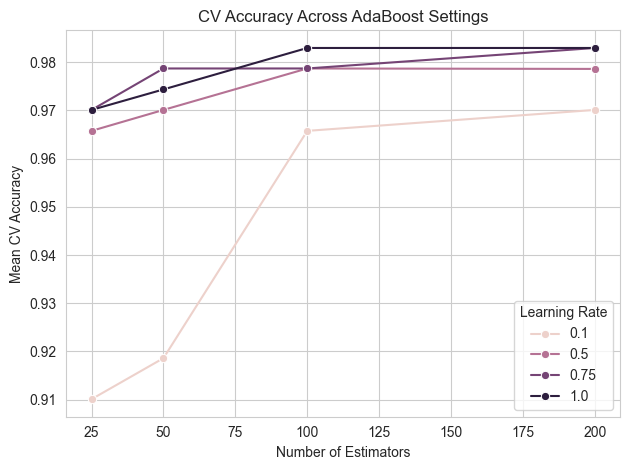

In [4]:
import seaborn as sns
import matplotlib.pyplot as plt

sns.lineplot(
    data=results,
    x='param_classifier__n_estimators',
    y='mean_test_score',
    hue='param_classifier__learning_rate',
    marker='o'
)
plt.title("CV Accuracy Across AdaBoost Settings")
plt.ylabel("Mean CV Accuracy")
plt.xlabel("Number of Estimators")
plt.legend(title='Learning Rate')
plt.tight_layout()

## Gradient Boost and XGBoost

[GradientBoost] Best Params: {'classifier__learning_rate': 0.05, 'classifier__max_depth': 3, 'classifier__n_estimators': 100}
[GradientBoost] Test Classification Report:
              precision    recall  f1-score   support

      Adelie       0.96      0.98      0.97        44
   Chinstrap       1.00      0.95      0.97        20
      Gentoo       0.97      0.97      0.97        36

    accuracy                           0.97       100
   macro avg       0.98      0.97      0.97       100
weighted avg       0.97      0.97      0.97       100



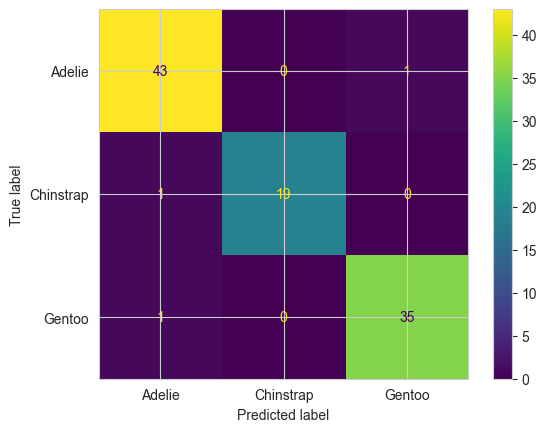

In [5]:
from sklearn.ensemble import GradientBoostingClassifier
from xgboost import XGBClassifier
from sklearn.pipeline import Pipeline
from sklearn.model_selection import GridSearchCV, StratifiedKFold
from sklearn.metrics import classification_report, ConfusionMatrixDisplay

gb_pipe = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('classifier', GradientBoostingClassifier(random_state=123))
])

gb_param_grid = {
    'classifier__n_estimators': [20, 50, 100, 200],
    'classifier__learning_rate': [0.05, 0.1, 0.15, 0.2],
    'classifier__max_depth': [1, 3]
}

gb_grid = GridSearchCV(
    gb_pipe,
    param_grid=gb_param_grid,
    cv=StratifiedKFold(n_splits=5, shuffle=True, random_state=123),
    scoring='accuracy',
    n_jobs=-1
)

gb_grid.fit(X_train, y_train)

best_gb = gb_grid.best_estimator_
y_pred_gb = best_gb.predict(X_test)

print(f"[GradientBoost] Best Params: {gb_grid.best_params_}")
print("[GradientBoost] Test Classification Report:")
print(classification_report(y_test, y_pred_gb))
ConfusionMatrixDisplay.from_estimator(best_gb, X_test, y_test)

[XGBoost] Best Params: {'classifier__learning_rate': 0.05, 'classifier__max_depth': 3, 'classifier__n_estimators': 100}
[XGBoost] Test Classification Report:
              precision    recall  f1-score   support

      Adelie       0.98      0.98      0.98        44
   Chinstrap       1.00      0.95      0.97        20
      Gentoo       0.97      1.00      0.99        36

    accuracy                           0.98       100
   macro avg       0.98      0.98      0.98       100
weighted avg       0.98      0.98      0.98       100



C:\Users\isabe\PycharmProjects\GSB-545\gsb545env\Lib\site-packages\xgboost\training.py:183: UserWarning: [19:23:31] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


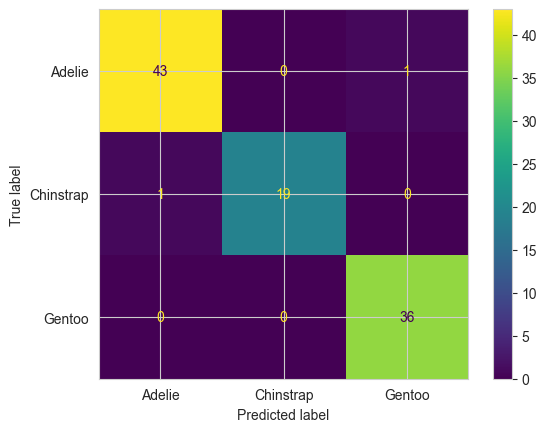

In [6]:
from sklearn.preprocessing import LabelEncoder

# Encode string class labels as integers
le = LabelEncoder()
y_train_encoded = le.fit_transform(y_train)
y_test_encoded = le.transform(y_test)

xgb_pipe = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('classifier', XGBClassifier(use_label_encoder=False, eval_metric='mlogloss', random_state=123))
])

xgb_param_grid = {
    'classifier__n_estimators': [20, 50, 100, 200],
    'classifier__learning_rate': [0.05, 0.1, 0.15, 0.2],
    'classifier__max_depth': [3, 5]
}

xgb_grid = GridSearchCV(
    xgb_pipe,
    param_grid=xgb_param_grid,
    cv=StratifiedKFold(n_splits=5, shuffle=True, random_state=123),
    scoring='accuracy',
    n_jobs=-1
)

xgb_grid.fit(X_train, y_train_encoded)
best_xgb = xgb_grid.best_estimator_
y_pred_xgb = best_xgb.predict(X_test)
y_pred_xgb_labels = le.inverse_transform(y_pred_xgb)

print(f"[XGBoost] Best Params: {xgb_grid.best_params_}")
print("[XGBoost] Test Classification Report:")
print(classification_report(y_test, y_pred_xgb_labels))
ConfusionMatrixDisplay.from_predictions(y_test, y_pred_xgb_labels)


In [7]:
gb_results = pd.DataFrame(gb_grid.cv_results_)
gb_results['Model'] = 'GradientBoost'

xgb_results = pd.DataFrame(xgb_grid.cv_results_)
xgb_results['Model'] = 'XGBoost'

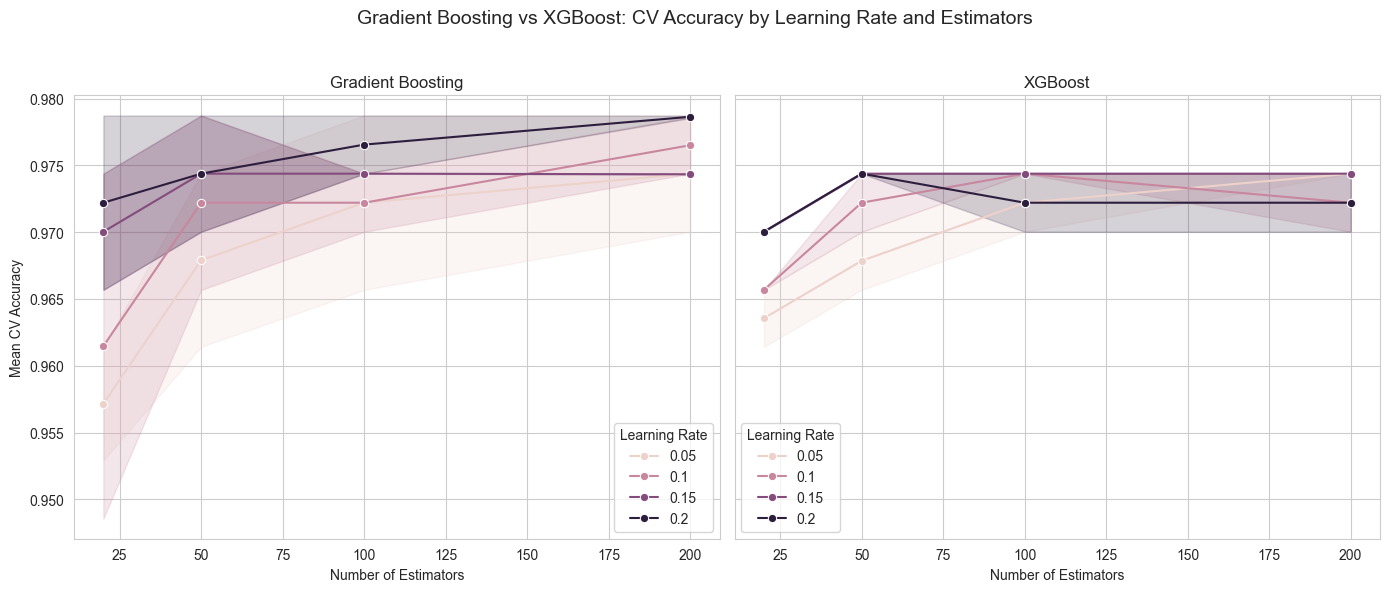

In [8]:
import matplotlib.pyplot as plt
import seaborn as sns

boost_results = pd.concat([gb_results, xgb_results], ignore_index=True)

# Set up subplots
fig, axes = plt.subplots(1, 2, figsize=(14, 6), sharey=True)

# Gradient Boosting subplot
sns.lineplot(
    data=boost_results[boost_results["Model"] == "GradientBoost"],
    x="param_classifier__n_estimators",
    y="mean_test_score",
    hue="param_classifier__learning_rate",
    marker="o",
    ax=axes[0]
)
axes[0].set_title("Gradient Boosting")
axes[0].set_xlabel("Number of Estimators")
axes[0].set_ylabel("Mean CV Accuracy")
axes[0].legend(title="Learning Rate")

# XGBoost subplot
sns.lineplot(
    data=boost_results[boost_results["Model"] == "XGBoost"],
    x="param_classifier__n_estimators",
    y="mean_test_score",
    hue="param_classifier__learning_rate",
    marker="o",
    ax=axes[1]
)
axes[1].set_title("XGBoost")
axes[1].set_xlabel("Number of Estimators")
axes[1].legend(title="Learning Rate")

plt.suptitle("Gradient Boosting vs XGBoost: CV Accuracy by Learning Rate and Estimators", fontsize=14)
plt.tight_layout(rect=[0, 0, 1, 0.95])
plt.show()

## Visualizing Boosting Performance Across Settings

The plot below shows how Gradient Boosting and XGBoost respond to different values of `learning_rate` and `n_estimators`, the two most influential hyperparameters in these boosting models.

### Key Takeaways:

#### Gradient Boosting:

- Accuracy consistently improves as the number of estimators increases.
- Higher learning rates (0.15 and 0.2) perform best, suggesting this model benefits from slightly more aggressive learning.
- The gains are steady and smooth Gradient Boosting is **very stable** in how it learns.

#### XGBoost:

- Performs best with a moderate learning rate (0.1 or 0.15)** and fewer estimators.
- Increasing the number of estimators doesn't always help in fact, performance slightly flattens or dips at higher estimator counts.
- XGBoost appears more sensitive to tuning, but can match or exceed Gradient Boosting if dialed in well.

This comparison shows that:
- **Gradient Boosting** offers more predictable improvements when increasing model complexity.
- **XGBoost** is more nuanced and requires more careful tuning, but can yield good results with fewer trees.

## Final Test Set Performance: Boosting Model Comparison

| Model           | Accuracy | Best Params                                  |
|----------------|----------|----------------------------------------------|
| **AdaBoost**   | 0.96     | learning_rate=0.75, n_estimators=200         |
| **GradientBoosting** | 0.97 | learning_rate=0.05, max_depth=3, n_estimators=100 |
| **XGBoost**     | 0.98     | learning_rate=0.05, max_depth=3, n_estimators=100 |


## Final Thoughts: Which Boosting Model Worked Best?

All three boosting models performed very well consistently achieving 96%–98% accuracy on the test set. Here’s what I observed:

- **XGBoost** had the highest accuracy overall. It’s efficient and powerful, especially when well-tuned. It performed best at a low learning rate and shallow depth suggesting it doesn't need much complexity to be effective on this dataset.
  
- **Gradient Boosting** was extremely stable across different parameter settings. It improved smoothly with more estimators and higher learning rates, and delivered strong performance without being too sensitive to tuning.

- **AdaBoost** performed slightly lower than the other two. It was more sensitive to learning rate, and needed a higher number of estimators to match their performance. That said, it’s still a very strong model when simplicity is important.
